# JIND-Multi Notebook Tutorial

This notebook provides a step-by-step guide on how to run the JIND-Multi method using the Pancreas scRNA-seq dataset as an example. Specifically, batch 0 will be used as the source, batch 2 as the target, and batch 1 as an additional intermediate dataset. Since we have labels for the target batch, we will use confusion matrices to evaluate the results.

## 1. Initial Setup

First, let's ensure we have the necessary dependencies and import the `jind_multi` package.

In [1]:
import sys
import os
import ast

# Get the path to the project root directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the path to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

# Import the jind_multi package
import jind_multi

# 2. Configuring Parameters

In this section, we define the inputs required for running JIND-Multi by specifying various parameters. These inputs include:

- **Path to the `.h5ad` file**: This is the location of the data file containing the single-cell RNA sequencing data.
- **Batch and cell type column names**: We specify the column names for batch information and cell types within the AnnData object.
- **Source and target batch names**: We indicate which batch will be used as the source for annotation transfer and which batch will be the target for annotation.
- **Output path**: This is where the results of the analysis will be saved.
- **Training configurations**: These include the number of features to consider in the model, the minimum number of cells required per cell type for training in each batch, and whether to use a GPU for computation.
- **Intermediate datasets**: The `TRAIN_DATASETS_NAMES` parameter specifies which batches are used as intermediate datasets for training. These datasets, excluding the source and target batches, help in improving the model’s performance by providing additional training data.

We define these parameters in the `Args` class, which will be used to configure and run the JIND-Multi method.


In [17]:
class Args:
    PATH = "../resources/data/pancreas/pancreas.h5ad"  # path to your data
    BATCH_COL = "batch" # Column name for batch information in the AnnData object
    LABELS_COL = "celltype" # Column name for cell types in the AnnData object
    SOURCE_DATASET_NAME = "0" # Name of the source batch
    TARGET_DATASET_NAME = "2" # Name of the target batch
    OUTPUT_PATH = "../results/pancreas" # Directory to save results
    PRETRAINED_MODEL_PATH = "" # Path to pre-trained models, if available (here we are not introducing any)
    TRAIN_DATASETS_NAMES = "['1']" # List of intermediate datasets for training
    NUM_FEATURES = 5000 # Number of features (genes) to consider for modeling
    MIN_CELL_TYPE_POPULATION = 100 # Minimum number of cells required per cell type for training
    USE_GPU = True # Whether to use GPU for computation

args = Args() 
print(args.PATH)

../resources/data/pancreas/pancreas.h5ad


# 3. Setting Up the Training Configuration
We adjust the training configuration according to the specified parameters.

In [18]:
# Set up training configuration (you can modify more things here)
config = jind_multi.get_config()
config['data']['num_features'] = args.NUM_FEATURES
config['data']['min_cell_type_population'] = args.MIN_CELL_TYPE_POPULATION
config['train_classifier']['cuda'] = args.USE_GPU  
config['GAN']['cuda'] = args.USE_GPU  
config['ftune']['cuda'] = args.USE_GPU  
print(f'USE_GPU: {args.USE_GPU}')
print(config)

USE_GPU: True
{'ftune_intermediate': True, 'retrain_intermediate': True, 'align_target_to_source': False, 'plot_tsne': False, 'cmat_print_counts': True, 'save_results_to_sheets': True, 'train_classifier': {'val_frac': 0.2, 'seed': 0, 'batch_size': 128, 'cuda': True, 'epochs': 15}, 'GAN': {'seed': 0, 'batch_size': 128, 'cuda': True, 'epochs': 15, 'epochs_da': 15, 'gdecay': 0.01, 'ddecay': 0.001, 'maxcount': 7, 'val_frac': 0.1, 'version': 'domain_adapt'}, 'ftune': {'version': 'ftune', 'val_frac': 0.1, 'seed': 0, 'batch_size': 32, 'cuda': True, 'epochs': 15, 'epochs_intermediate': 5, 'retrain_encoder': True, 'use_all_labels': True, 'mini_batch_len': 'MAX', 'mini_batch_splits': 1, 'ftune_retrain_model_epochs': 5, 'metric': 'accuracy'}, 'data': {'count_normalize': True, 'log_transformation': True, 'num_features': 5000, 'min_cell_type_population': 100, 'max_cells_for_dataset': 50000, 'test_data_path': '../resources/data/test/', 'human_brain_neurips_data_path': '../resources/data/human_brain/

# 4. Loading and Processing Data
We load and process the data using the `load_and_process_data` function from the `jind_multi` package. Then, we divide the data into training and test sets.

In [19]:
# Load and process the data
data = jind_multi.load_and_process_data(args, config) 

# Split into training and test datasets
train_data = data[data['batch'] != args.TARGET_DATASET_NAME]
test_data = data[data['batch'] == args.TARGET_DATASET_NAME]

/opt/anaconda3/envs/jind/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/anaconda3/envs/jind/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


[Utils] Variance based dimension reduction ...
[Utils][filter_cells] Batch '0': epsilon only has 18 cells (min cell type population = 100)
[Utils][filter_cells] Batch '2': endothelial only has 16 cells (min cell type population = 100)
[Utils][filter_cells] Batch '2': epsilon only has 7 cells (min cell type population = 100)
[Utils][filter_cells] Batch '1': endothelial only has 21 cells (min cell type population = 100)
[Utils][filter_cells] Batch '1': epsilon only has 3 cells (min cell type population = 100)
[Utils][filter_cells] Cell type population count in data:  ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [1362 4024 3243  908 1708  553]
[Utils] 0:  (7742, 2450) ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [ 958 2326 2525  601 1077  255]
[Utils] 2:  (2038, 2450) ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [185 886 270 114 386 197]
[Utils] 1:  (2018, 2450) ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [219 812 448 193 245 101]


# 5. Creating the JIND-Multi Object
We create an instance of the JindWrapper class, which encapsulates the functionality of JIND-Multi, including training and evaluating the model.

In [10]:
# Create the JIND-Multi object
train_datasets_names = ast.literal_eval(args.TRAIN_DATASETS_NAMES)  # Parse as list if not None

jind = jind_multi.JindWrapper(
    train_data=train_data, 
    train_dataset_names=train_datasets_names,  
    source_dataset_name=args.SOURCE_DATASET_NAME, 
    output_path=args.OUTPUT_PATH,
    config=config
)

# 6. Training the Model
Now we train the model and we infer the labels on the test dataset (target batch).

In [ ]:
# Train the JIND-Multi model
jind.train(target_data=test_data)

In [ ]:
# 7. Evaluating Results

# para este apartado conseguir que el metodo NO PLOTEE las confusion matrices y que sea yo el que los plotee aqui.
#Since we have labels for the target batch, we will use confusion matrices to evaluate the results. Confusion matrices will show the performance of the model in terms of correctly and incorrectly predicted cell types, as well as unassigned cells.

## 8. Applying the Trained Model to a New Target Batch

Once the model has been trained, you may want to apply it to a new target batch. This process involves loading the pre-trained model from the saved directory and using it to make predictions on new data.

### Steps:

1. **Specify the Path to Pre-Trained Models**: Ensure that the path to the directory containing the trained models is correctly set. This directory should include the model files (`.pt` format) and the associated configuration files.

2. **Load the Pre-Trained Model**: Use the `JindWrapper` class to load the pre-trained model from the specified directory.

3. **Apply the Model to the New Target Batch**: Run the model on the new target batch to get predictions.

Here’s how you can do this in code for batch 3:

In [9]:
# Define new parameters for applying the model to a new target batch
class Args:
    PATH = "../resources/data/pancreas/pancreas.h5ad"  # path to your data
    BATCH_COL = "batch" # Column name for batch information in the AnnData object
    LABELS_COL = "celltype" # Column name for cell types in the AnnData object
    SOURCE_DATASET_NAME = "0" # Name of the source batch
    TARGET_DATASET_NAME = "3" # Name of the target batch
    OUTPUT_PATH = "../results/pancreas_target3" # Directory to save results
    PRETRAINED_MODEL_PATH = "../results/pancreas/trained_models" # Path to pre-trained models, if available (here we are not introducing any)
    TRAIN_DATASETS_NAMES = "['1']" # List of intermediate datasets for training
    NUM_FEATURES = 5000 # Number of features (genes) to consider for modeling
    MIN_CELL_TYPE_POPULATION = 5 # Minimum number of cells required per cell type for training
    USE_GPU = True # Whether to use GPU for computation

args = Args() 
print(args.PATH)

# Set up training configuration
config = jind_multi.get_config()
config['data']['num_features'] = args.NUM_FEATURES
config['data']['min_cell_type_population'] = args.MIN_CELL_TYPE_POPULATION
config['train_classifier']['cuda'] = args.USE_GPU  
config['GAN']['cuda'] = args.USE_GPU  
config['ftune']['cuda'] = args.USE_GPU  
print(f'USE_GPU: {args.USE_GPU}')
print(config)

# Load and process the data
data = jind_multi.load_and_process_data(args, config) 

../resources/data/pancreas/pancreas.h5ad
USE_GPU: True
{'ftune_intermediate': True, 'retrain_intermediate': True, 'align_target_to_source': False, 'plot_tsne': False, 'cmat_print_counts': True, 'save_results_to_sheets': True, 'train_classifier': {'val_frac': 0.2, 'seed': 0, 'batch_size': 128, 'cuda': True, 'epochs': 15}, 'GAN': {'seed': 0, 'batch_size': 128, 'cuda': True, 'epochs': 15, 'epochs_da': 15, 'gdecay': 0.01, 'ddecay': 0.001, 'maxcount': 7, 'val_frac': 0.1, 'version': 'domain_adapt'}, 'ftune': {'version': 'ftune', 'val_frac': 0.1, 'seed': 0, 'batch_size': 32, 'cuda': True, 'epochs': 15, 'epochs_intermediate': 5, 'retrain_encoder': True, 'use_all_labels': True, 'mini_batch_len': 'MAX', 'mini_batch_splits': 1, 'ftune_retrain_model_epochs': 5, 'metric': 'accuracy'}, 'data': {'count_normalize': True, 'log_transformation': True, 'num_features': 5000, 'min_cell_type_population': 5, 'max_cells_for_dataset': 50000, 'test_data_path': '../resources/data/test/', 'human_brain_neurips_data

In [ ]:
# Split into training and test datasets
train_data = data[data['batch'] != args.TARGET_DATASET_NAME]
test_data = data[data['batch'] == args.TARGET_DATASET_NAME]

# Create the JIND-Multi object
jind2 = jind_multi.JindWrapper(
                                train_data=train_data, 
                                source_dataset_name=args.SOURCE_DATASET_NAME, 
                                output_path=args.OUTPUT_PATH,
                                config=config,
                            )

### Loading and Applying the Pre-Trained Model

After setting up your parameters and preparing the data, the next step is to load the pre-trained model and use it for predictions on the new target batch. This process involves several steps:

This step identifies the files containing the pre-trained models stored in the specified directory and loads validation statistics used to evaluate the performance of the pre-trained model.

In [ ]:
print('Loading pre-trained models from specified path...')
file_paths = jind_multi.find_saved_models(args.PRETRAINED_MODEL_PATH, train_data)  # Check if pre-trained models are available
print(file_paths)
model = jind_multi.load_trained_models(file_paths, train_data, args.SOURCE_DATASET_NAME)
print(model)
print("Loading validation statistics...")
val_stats = jind_multi.load_val_stats(args.PRETRAINED_MODEL_PATH, 'val_stats_trained_model.json')
print(val_stats)

**Applying the Model to the New Target Batch:**


[load_trained_models] Already trained models found in file_paths.
[load_trained_models] Load the Source Classifier Model
[load_trained_models] Trained Classifier Dataset Name: 0
[load_trained_models] Add loaded model to saved model dictionary
[load_trained_models] Load the rest of intermediate models
[load_trained_models] Trained Intermediate model name: 1
[load_trained_models] Add loaded model to saved model dictionary
{'0': Classifier(
  (fc1): Sequential(
    (0): Linear(in_features=2448, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): GaussianNoise()
  )
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=6, bias=True)
  )
), '1': ClassifierBig(
  (m1): Classifier(
    (fc1): Sequential(
      (0): Linear(in_features=2448, out_features=256, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): GaussianNoise()
    )
    (fc): Sequential(


  0%|          | 0/40 [00:00<?, ?it/s]

[JindWrapper] Removing batch effect by mapping {'3'} onto {'1', '0'}
[JindLib] Using custom model for dataset 1
[JindLib] Using custom model for dataset 0
[JindLib] Using custom model for dataset 3
[JindLib] Updated Rejected cells from 1.000 to 0.756


Epoch 2 G Loss: 0.713 D Loss: 0.598:   2%|▎         | 1/40 [00:00<00:04,  8.74it/s]

[JindLib] Using custom model for dataset 3
Updated Rejected cells from 0.756 to 0.109


Epoch 3 G Loss: 0.853 D Loss: 0.583:   2%|▎         | 1/40 [00:00<00:03,  9.94it/s]

[JindLib] Using custom model for dataset 3
Updated Rejected cells from 0.109 to 0.072


Epoch 9 G Loss: 0.801 D Loss: 0.636: 100%|██████████| 40/40 [00:04<00:00,  9.54it/s]


Loss not improving, stopping alignment
[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 430 #Rej 31 (7.2%) corrct 392 (raw 93.023% eff 98.246%) incorrct 7 mAP 83.193%  {'3'}


Epoch 0: Loss 0.0013: Dataset 3::  33%|███▎      | 4/12 [00:00<00:00, 35.54it/s]

[JindWrapper] Fine tuning JIND for {'3'} dataset
[JindLib] Using custom model for dataset 3
[JindLib] Using 393 high confidence cells out of 430 for fine tuning


Epoch 0: Loss 0.0006: Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 38.90it/s]


Validation accuracy = 1.0000. Loss = 0.0006 {'3': 1.0}


Epoch 1: Loss 0.0 : Dataset 3::  42%|████▏     | 5/12 [00:00<00:00, 40.49it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 1: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 38.09it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 2: Loss 0.0 : Dataset 3::  33%|███▎      | 4/12 [00:00<00:00, 39.68it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 2: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 30.98it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 3: Loss 0.0 : Dataset 3::  42%|████▏     | 5/12 [00:00<00:00, 40.18it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 3: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 39.52it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 4: Loss 0.0 : Dataset 3::  42%|████▏     | 5/12 [00:00<00:00, 41.76it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 4: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 41.07it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 5: Loss 0.0 : Dataset 3::  42%|████▏     | 5/12 [00:00<00:00, 42.07it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 5: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 40.64it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 6: Loss 0.0 : Dataset 3::  42%|████▏     | 5/12 [00:00<00:00, 40.79it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 6: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 39.23it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 7: Loss 0.0 : Dataset 3::  33%|███▎      | 4/12 [00:00<00:00, 39.88it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 7: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 39.13it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 8: Loss 0.0 : Dataset 3::  33%|███▎      | 4/12 [00:00<00:00, 39.89it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 8: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 40.72it/s]


Epoch     9: reducing learning rate of group 0 to 5.0000e-05.
Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 9: Loss 0.0 : Dataset 3::  42%|████▏     | 5/12 [00:00<00:00, 41.01it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 9: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 40.98it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 10: Loss 0.0 : Dataset 3::  33%|███▎      | 4/12 [00:00<00:00, 39.65it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 10: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 31.63it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 11: Loss 0.0 : Dataset 3::  42%|████▏     | 5/12 [00:00<00:00, 41.02it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 11: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 40.67it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 12: Loss 0.0 : Dataset 3::   0%|          | 0/12 [00:00<?, ?it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 12: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 39.90it/s]


Epoch    13: reducing learning rate of group 0 to 2.5000e-05.
Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 13: Loss 0.0 : Dataset 3::  42%|████▏     | 5/12 [00:00<00:00, 41.00it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 13: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 40.17it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 14: Loss 0.0 : Dataset 3::   0%|          | 0/12 [00:00<?, ?it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 14: Loss 0.0 : Dataset 3:: 100%|██████████| 12/12 [00:00<00:00, 31.75it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}
[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 393 #Rej 0 (0.0%) corrct 393 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}
[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 430 #Rej 28 (6.5%) corrct 393 (raw 94.186% eff 97.761%) incorrct 9 mAP 84.265%  {'3'}
[JindWrapper] Getting the test labels predictions
[JindLib] Using custom model for dataset 3
predicted_label
              raw_predictions predictions        acinar         alpha  \
cellname                                                                
reads.12732-3           alpha       alpha  1.969831e-23  1.000000e+00   
reads.12733-3           alpha       alpha  1.313718e-15  1.000000e+00   
reads.12736-3          ductal      ductal  2.241360e-12  5.275986e-12   
reads.12737-3           alpha       alpha  9.742308e-22  1.000000e+00   
reads.12738-3          ductal      ductal  6.013591e-14  1.258385e-13   
...

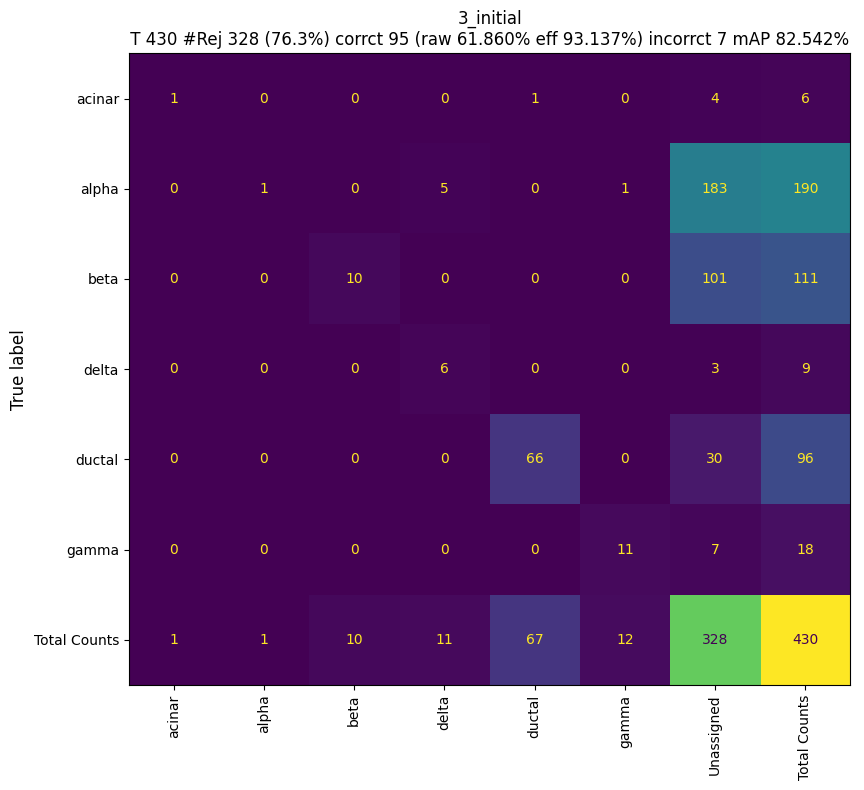

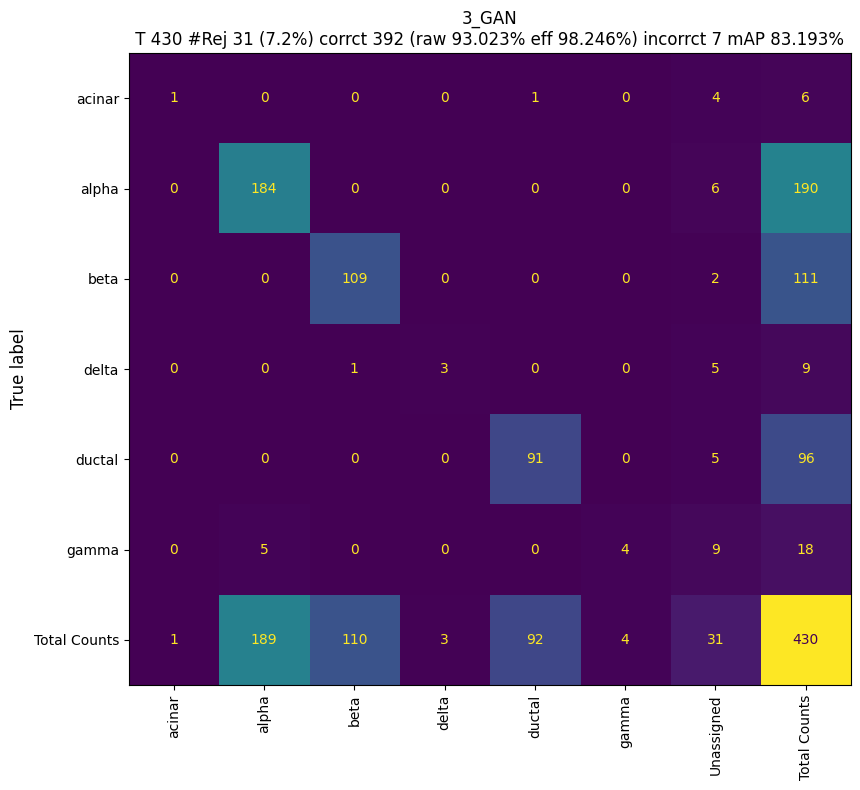

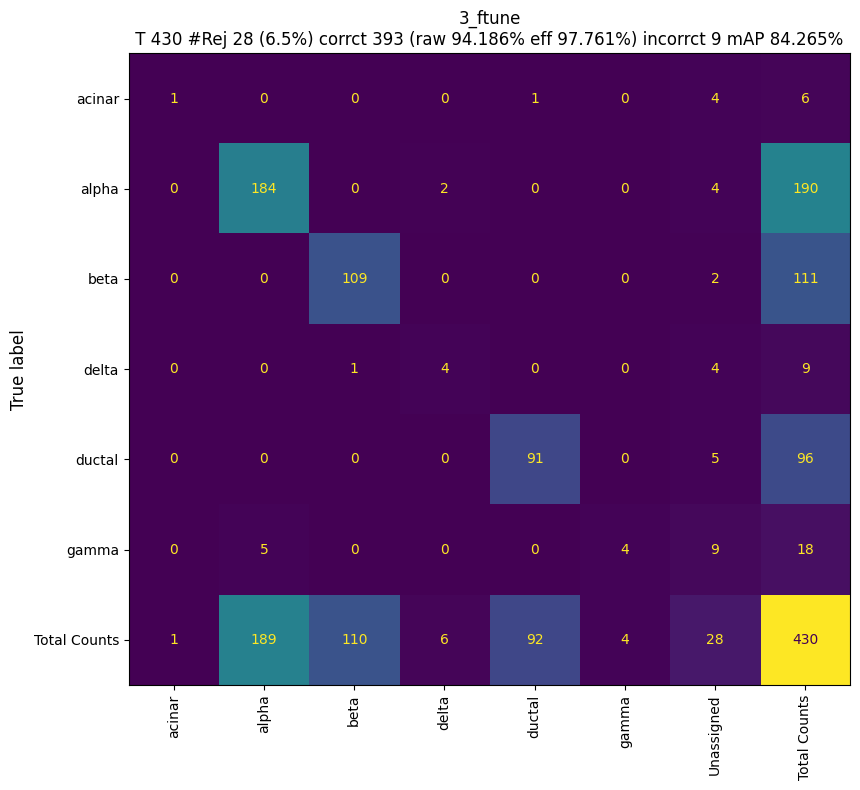

In [16]:
# Do JIND
jind2.train(target_data=test_data, model=model, val_stats=val_stats)

In [ ]:
Conclusion
This notebook demonstrated how to configure and run JIND-Multi for single-cell RNA sequencing data using the Pancreas dataset. It illustrated how to set parameters, load and process data, and evaluate the model using confusion matrices. Adjust parameters and review the results to suit your specific dataset and research needs.

For more detailed information on interpreting the results, refer to the JIND-Multi package documentation and the output files generated in the OUTPUT_PATH.